# Import and show graph

In [1]:
from numpy import *; from matplotlib.pyplot import *
from testFunctions import testSimpleGraph
import fastIsing
import networkx as nx
import plotting as plotz

graph = nx.DiGraph()
graph.add_edge(0, 1, J = 1)
graph.add_edge(1, 2, J = 1)
graph.add_edge(2, 3, J = 1)
graph.add_edge(3, 4, J = 1)
nx.set_edge_attributes(graph, {edge : 1 for edge in graph.edges()}, 'J')
nx.set_node_attributes(graph, 0, 'H'); nx.set_node_attributes(graph, 0, 'nudges')
for node in graph.nodes():
    graph.nodes[node]['state'] = 1 if random.rand() < .5 else -1

plotz.showGraph(graph)
show()

# Fit temperature to a target entropy

In [2]:
# targetEntropy, temperatures = .5, linspace(0, 15, 1)
# T, H = fastIsing.fitTemperatureToNodeProbability(Htarget = targetEntropy, temperatures = temperatures, graph = graph)

# show sampled temperature vs entropy

In [3]:
# fig, ax = subplots(); 
# ax.plot(temperatures, H, '.'); setp(ax, **dict(xlabel = 'temperature', ylabel = 'Entropy avg prob node'))
# ax.set_title('entropy target temp {}'.format(T))
# show()

In [4]:
# Simulate model at the temperature found abouve

In [5]:
Tnew = .68 # T doesnt match so asuming this now
model = fastIsing.Ising(temperature = Tnew, graph = graph, doBurnin = True,
                       mode = 'async')

Initialized ISING model with 
temperature: 0.68
mode: async
Starting burnin


In [6]:
import information
nSamples, step, deltas, repeats = 500, 2*model.nNodes + 1, 10, 500
import time
now = time.time()
resSink  = information.mutualInformationShiftNode(model = model, nSamples = nSamples, \
                                                    step = step, deltas = deltas, repeats = repeats)
resSource = information.mutualInformationShiftState(model = model, nSamples = nSamples, \
                                                    step = step, deltas = deltas, repeats = repeats)
print(time.time() - now)

Constructing conditional probability per state
Spawning parallel processes
(28, 500, 11, 5)


/home/casper/Projects/information-theory/information.py:120: RuntimeWarning: invalid value encountered in true_divide
  pNodeGivenState[..., i] /= pState
/home/casper/Projects/information-theory/information.py:183: RuntimeWarning: divide by zero encountered in log2
  return -nansum(p * log2(p), axis = -1)
/home/casper/Projects/information-theory/information.py:183: RuntimeWarning: invalid value encountered in multiply
  return -nansum(p * log2(p), axis = -1)


Constructing conditional probability per state
Spawning parallel processes
93.76837468147278


/home/casper/Projects/information-theory/information.py:165: RuntimeWarning: invalid value encountered in true_divide
  pNodeGivenState[..., i] /= pState


# show MI source sink

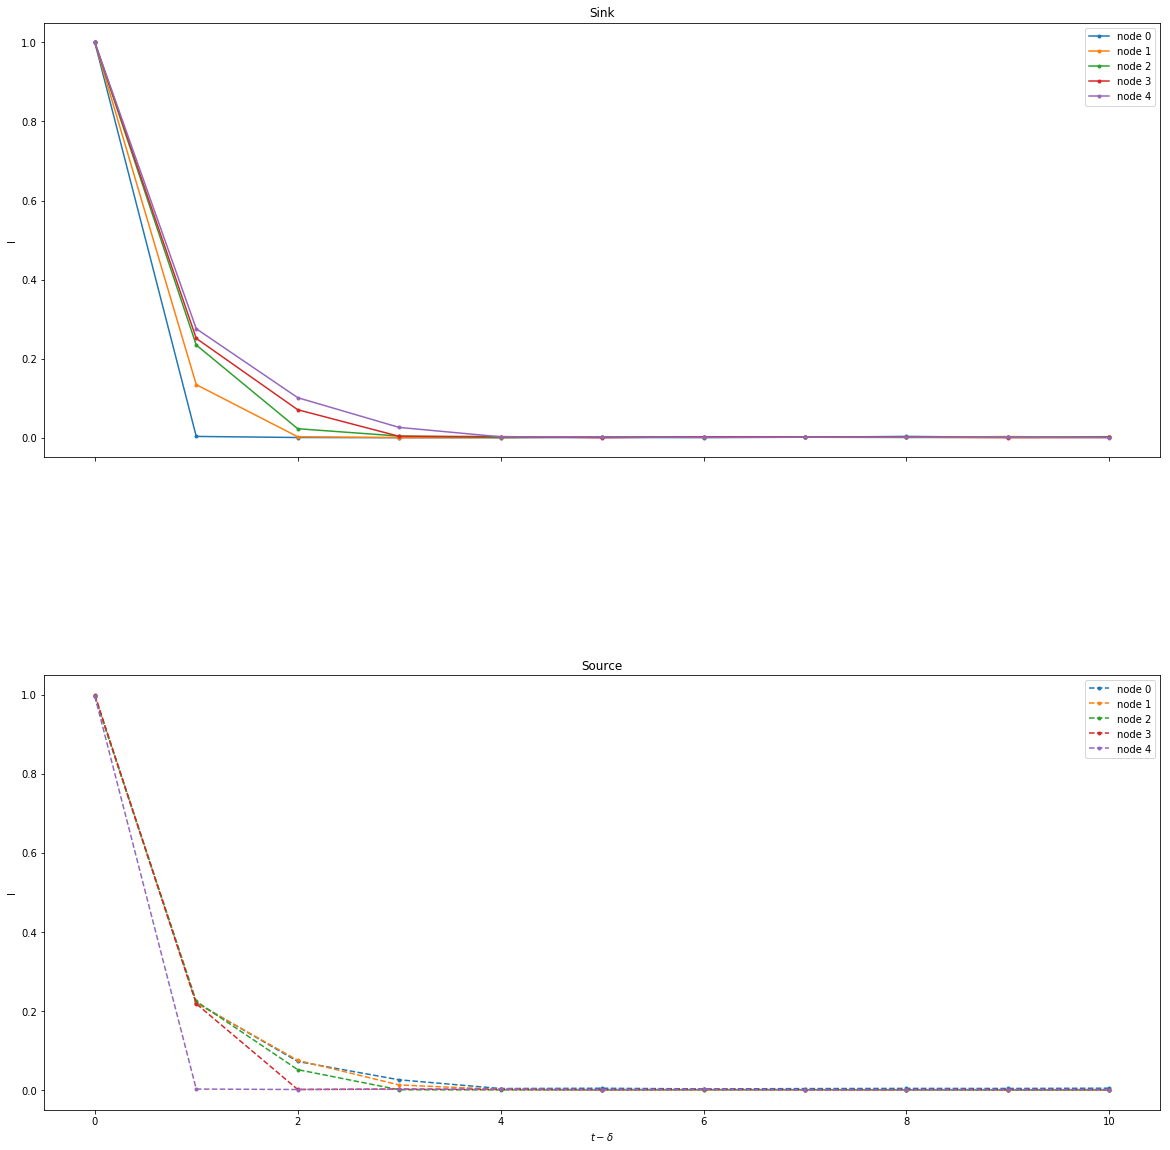

In [7]:
# striped is source, whole is sink method
colors = get_cmap('tab10')(arange(model.nNodes))
fig, ax = subplots(2, sharex = 'all', sharey = 'all', figsize = (20,20))
ax = ax.flatten()
for nodeIdx, (Isink, Isource) in enumerate(zip(resSink[-1], resSource[-1])):
    ax[0].plot(Isink, '.-', c = colors[nodeIdx, :], label = 'node {}'.format(nodeIdx))
    ax[1].plot(Isource,'.--', c = colors[nodeIdx, :], label = 'node {}'.format(nodeIdx))
setp(ax, **dict(ylabel = 'I')); ax[-1].set_xlabel('$t - \delta$')
[axi.legend() for axi in ax]
[axi.set_title(title) for axi, title in zip(ax, 'Sink Source'.split(' ' ))]
subplots_adjust(hspace = .5)
show()

# Assume single exponential

In [8]:

func = lambda x, a, c, d: a * exp(c * x + d)
curveDataSink, coefsSink  = plotz.fit(resSink[-1].T, func = func) # only return relevant data
curveDataSource, coefsSource = plotz.fit(resSource[-1].T, func = func)
print(curveDataSink.shape) # nodes x [abs, rel, auc, error]

/home/casper/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(5, 4)


# show fits

[[  1.40258780e+00   1.22165591e-01   3.37920812e-01   2.53317885e-05]
 [  3.40316528e+00   3.40484678e-01   5.22003882e-01   2.48624129e-04]
 [  4.40035761e+00   4.61053640e-01   6.79614435e-01   9.12900750e-04]
 [  4.75159820e+00   5.03664242e-01   7.38405071e-01   2.22095995e-04]
 [  5.16469103e+00   5.54570443e-01   8.09688882e-01   5.20393862e-04]]
[[  4.53127647e+00   4.75329453e-01   6.97171534e-01   7.30847672e-04]
 [  4.51089420e+00   4.72926437e-01   6.93852739e-01   5.97199015e-04]
 [ -1.28366443e+00   0.00000000e+00  -7.44559730e-32   1.04573604e+00]
 [  4.17737047e+00   4.33837268e-01   6.42801595e-01   1.83711439e-03]
 [  1.34828238e+00   1.16764970e-01   3.35619712e-01   2.68644789e-05]]


[Text(0.5,1,'sink'), Text(0.5,1,'source')]

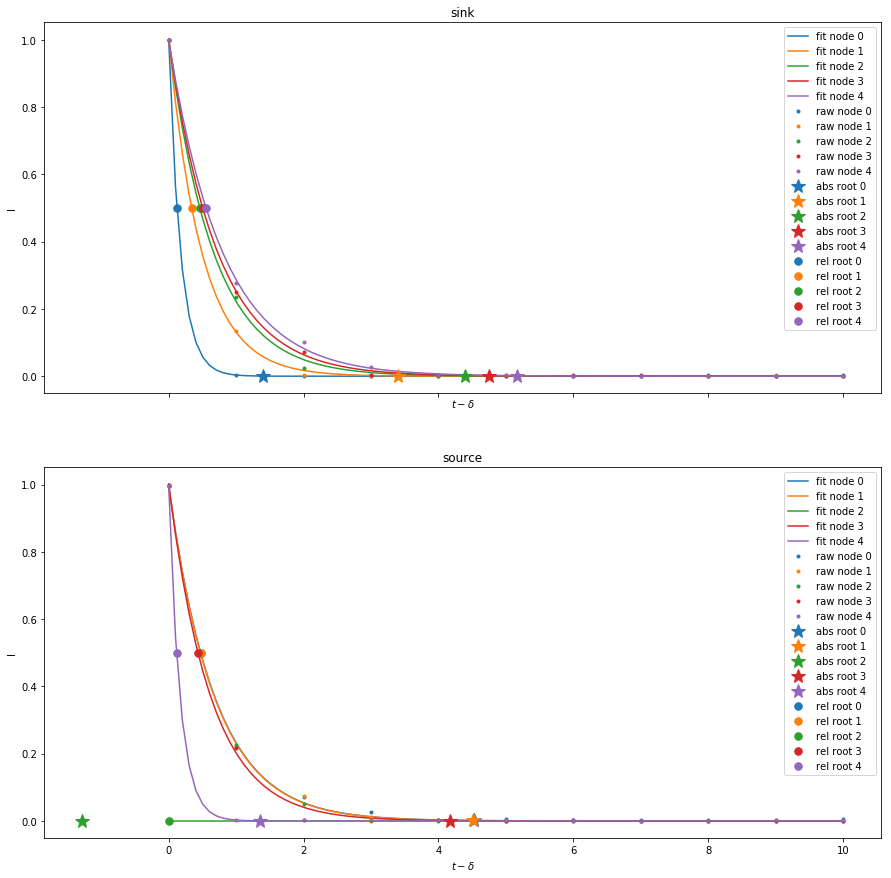

In [9]:
xr = linspace(0, 10, 100);
tmp = vstack((coefsSink, coefsSource))
I   = dstack((resSink[-1],  resSource[-1])).T
curveData = dstack((curveDataSink, curveDataSource)).T
fig, axes = subplots(len(tmp), figsize = (15, 15), sharex = 'all', sharey = 'all')
for ax, data, real, cd in zip(axes, tmp, I, curveData):
    [ax.plot(xr, func(xr, *c), label = 'fit node {}'.format(idx), c = colors[idx, :]) for idx, c in enumerate(data)]
    [ax.plot(i, '.', label = 'raw node {}'.format(idx), c = colors[idx, :]) for idx, i in enumerate(real.T)]
    [ax.plot(i, func(i, *c), '*', label = 'abs root {}'.format(idx), c = colors[idx, :], markersize = 15\
            ) for idx, (i, c) in enumerate(zip(cd[0, :], data))]
    [ax.plot(i, func(i, *c), '.', label = 'rel root {}'.format(idx), c = colors[idx, :], markersize = 15\
            ) for idx, (i, c) in enumerate(zip(cd[1, :], data))]
    
    print(cd.T)
    ax.legend()
    setp(ax, **dict(xlabel = '$t - \delta$', ylabel = 'I'))
    
[ax.set_title(i) for ax, i in zip(axes, 'sink source'.split(' '))]

# Show abs and rel idt

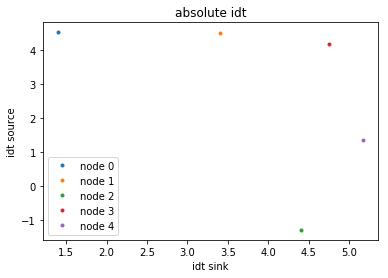

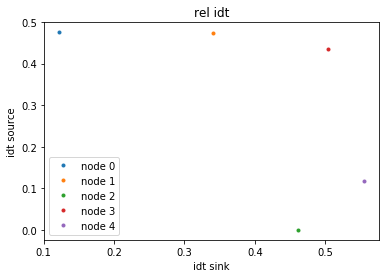

In [10]:

fig, ax = subplots()
[ax.plot(curveDataSink[idx, 0], curveDataSource[idx,0], \
         '.', c = colors[idx, :], label = 'node {}'.format(idx)) for idx in range(model.nNodes)]
setp(ax, **dict(xlabel = 'idt sink', ylabel = 'idt source', title = 'absolute idt'))
ax.legend()
# ax.set_ylim([0, 10])
show()

fig, ax = subplots()
[ax.plot(curveDataSink[idx, 1], curveDataSource[idx,1], \
         '.', c = colors[idx, :], label = 'node {}'.format(idx)) for idx in range(model.nNodes)]
setp(ax, **dict(xlabel = 'idt sink', ylabel = 'idt source', title = 'rel idt'))
ax.legend()
show()

# Assume double exponential

In [11]:
func = lambda x, a, b, c, d, f, g: f * exp(-a * x + b) + g * exp(-c * x + d)
curveDataSink, coefsSink  = plotz.fit(resSink[-1].T, func = func) # only return relevant data
curveDataSource, coefsSource = plotz.fit(resSource[-1].T, func = func)
print(curveDataSink.shape) # nodes x [abs, rel, auc, error]

/home/casper/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(5, 4)


# Show fits

[[  1.47645273e+00   1.20129214e-01   3.48025872e-01   4.86469076e-06]
 [  2.29526116e+00   3.61391718e-01   5.07306042e-01   7.74401828e-05]
 [  4.40037913e+00   4.61056166e-01   6.79617913e-01   9.12900755e-04]
 [  4.75159819e+00   5.03664280e-01   7.38405109e-01   2.22095996e-04]
 [  5.64960077e+00   4.52646832e-01   8.22350411e-01   1.67133067e-04]]
[[  5.39331858e+00   3.82623610e-01   7.18620520e-01   9.87074562e-05]
 [  5.16608884e+00   3.09650271e-01   7.09239053e-01   1.42078334e-04]
 [  4.43052493e+00   4.63927575e-01   6.81293193e-01   1.16382849e-04]
 [  4.17737518e+00   4.33837999e-01   6.42802527e-01   1.83711439e-03]
 [  1.89337175e+00   8.77179346e-02   3.49491798e-01   1.60247895e-06]]


[Text(0.5,1,'sink'), Text(0.5,1,'source')]

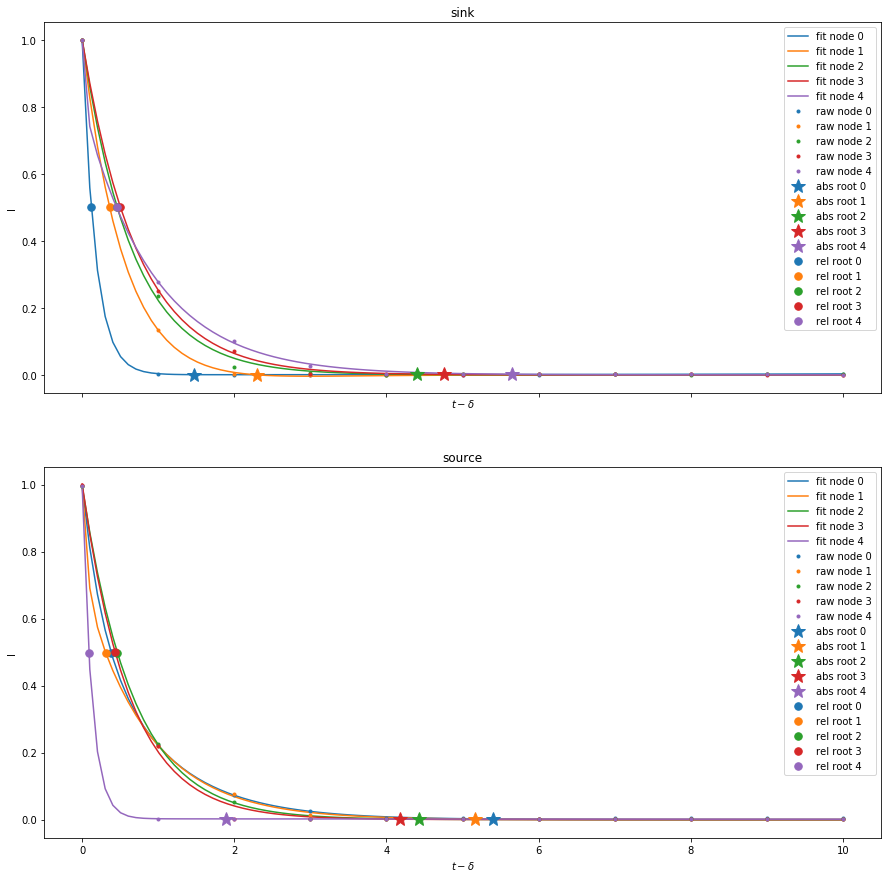

In [12]:
xr = linspace(0, 10, 100);
tmp = vstack((coefsSink, coefsSource))
I   = dstack((resSink[-1],  resSource[-1])).T
curveData = dstack((curveDataSink, curveDataSource)).T
fig, axes = subplots(len(tmp), figsize = (15, 15), sharex = 'all', sharey = 'all')
for ax, data, real, cd in zip(axes, tmp, I, curveData):
    [ax.plot(xr, func(xr, *c), label = 'fit node {}'.format(idx), c = colors[idx, :]) for idx, c in enumerate(data)]
    [ax.plot(i, '.', label = 'raw node {}'.format(idx), c = colors[idx, :]) for idx, i in enumerate(real.T)]
    [ax.plot(i, func(i, *c), '*', label = 'abs root {}'.format(idx), c = colors[idx, :], markersize = 15\
            ) for idx, (i, c) in enumerate(zip(cd[0, :], data))]
    [ax.plot(i, func(i, *c), '.', label = 'rel root {}'.format(idx), c = colors[idx, :], markersize = 15\
            ) for idx, (i, c) in enumerate(zip(cd[1, :], data))]
    
    print(cd.T)
    ax.legend()
    setp(ax, **dict(xlabel = '$t - \delta$', ylabel = 'I'))
    
[ax.set_title(i) for ax, i in zip(axes, 'sink source'.split(' '))]

# Show abs an rel idt

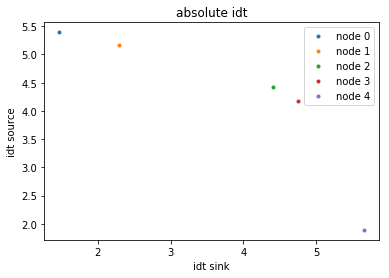

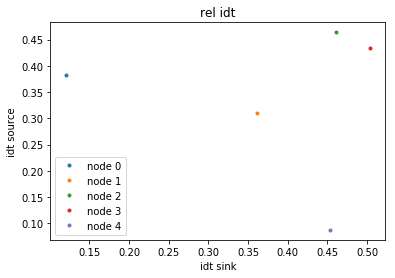

In [13]:

fig, ax = subplots()
[ax.plot(curveDataSink[idx, 0], curveDataSource[idx,0], \
         '.', c = colors[idx, :], label = 'node {}'.format(idx)) for idx in range(model.nNodes)]
setp(ax, **dict(xlabel = 'idt sink', ylabel = 'idt source', title = 'absolute idt'))
ax.legend()
# ax.set_ylim([0, 10])
show()

fig, ax = subplots()
[ax.plot(curveDataSink[idx, 1], curveDataSource[idx,1], \
         '.', c = colors[idx, :], label = 'node {}'.format(idx)) for idx in range(model.nNodes)]
setp(ax, **dict(xlabel = 'idt sink', ylabel = 'idt source', title = 'rel idt'))
ax.legend()
show()

In [14]:
[print(x,y) for x,y in zip(curveDataSink[:,[0,1]], curveDataSource[:,[0,1]])]

[ 1.47645273  0.12012921] [ 5.39331858  0.38262361]
[ 2.29526116  0.36139172] [ 5.16608884  0.30965027]
[ 4.40037913  0.46105617] [ 4.43052493  0.46392757]
[ 4.75159819  0.50366428] [ 4.17737518  0.433838  ]
[ 5.64960077  0.45264683] [ 1.89337175  0.08771793]


[None, None, None, None, None]